In [1]:
#def xop2_2d(g, f, a0, a):
from tqdm import tqdm
from tools.operators import xop_2d, yop_2d, Discrete1DGrid, RHSswe, RK3, initialize_vortex
from tools.plotting import VisualizeGrid, coLocateVelocity, StartPlot, UpdatePlot, StartPlotEnergy, UpdatePlotEnergy
from tools.tests import StabilityCheck, calc_diagnostics
import numpy as np
from matplotlib import pyplot as plt
import time

### Domain
-1 < x < 1, -1 < y < 1
Coriolis: f = 10
depth: H = 1 <br>
gravity: g = 10 <br>
tfinal: 1000000

visc = 1
bottom drag = 0

#### First Geometry - 80km resolution

In [2]:
#basin, resolution
xmin,xmax,N = -1, 1, 100
ymin,ymax,M = -1, 1, 100

# discretize x-y directions on a C-grid
xe,xc,dx = Discrete1DGrid(xmin,xmax,N)
ye,yc,dy = Discrete1DGrid(ymin,ymax,M)
xp,yp = np.meshgrid(xc,yc) # p-points
xu,yu = np.meshgrid(xe,yc) # u-points
xv,yv = np.meshgrid(xc,ye) # v-points
xz,yz = np.meshgrid(xe,ye) # z-points (vorticity)
dxs = np.array([dx,dy])    # grid size
# VisualizeGrid(xu,yu,xv,yv,xp,yp,xz,yz) # visualize grid optional
f0 = 10 #for flow?
f = 10 #for ICs
B = 1
gravity = 10
depth = np.ones([M,N])
coriolis = f0 - B*(yz)

In [3]:
# %matplotlib

In [4]:
coriolis

array([[11.  , 11.  , 11.  , ..., 11.  , 11.  , 11.  ],
       [10.98, 10.98, 10.98, ..., 10.98, 10.98, 10.98],
       [10.96, 10.96, 10.96, ..., 10.96, 10.96, 10.96],
       ...,
       [ 9.04,  9.04,  9.04, ...,  9.04,  9.04,  9.04],
       [ 9.02,  9.02,  9.02, ...,  9.02,  9.02,  9.02],
       [ 9.  ,  9.  ,  9.  , ...,  9.  ,  9.  ,  9.  ]])

In [5]:
# plt.close('all')

### initial conditions


In [6]:
L=0.1
a = .1 #?
u_trig = (1/np.cosh(yu/L))**2
u = ((gravity * a)/(f*L)) * u_trig

v = np.zeros_like(xv)

p = -a*(np.tanh(yp/L))

In [7]:
p[:,37] = 0

In [8]:
periodic = True

alin = 1 # toggles between linear (0), nonlinear (1) PDEs
visc = 0.001
cell_area = dx*dy
ntimesteps = 100000*3
isnap = 10       # frequency of visualization
finaltime = 1000
dt = finaltime/ntimesteps
StabilityCheck(gravity,depth,dt,dx)

max. Courant number: 0.5270462766947299
Stable gravity wave time step:


In [9]:
#reset indices for diagnostic calculations depending on BCs
if periodic:
    ind1u,ind2u = 1,len(u[0,])
    ind1v,ind2v = 1,len(v[0,])
    ind1p,ind2p = 1,len(p[0,])
    ind1z,ind2z = 1,len(coriolis[0,])
else:
    ind1u, ind2u = 0, len(u[0,])
    ind1v ,ind2v = 0, len(v[0,])
    ind1p ,ind2p = 0, len(p[0,])
    ind1z ,ind2z = 0, len(coriolis[0,])

In [10]:
initial_energy, initial_enstrophy, initial_mass = calc_diagnostics(u[:,ind1u:ind2u],v[:,ind1v:ind2v],p[:,ind1p:ind2p],dxs,depth[:,ind1p:ind2p],gravity,coriolis[:,ind1z:ind2z],alin)

### ADJUST P LEVS FOR PRESSURE CONTOURS


In [11]:
#set pmin manually since it drops slightly from beginning
plevs=np.linspace(-a,a,11)
xas,yas=4,4

In [12]:
%matplotlib

Using matplotlib backend: <object object at 0x000001F1960A6530>


In [13]:
fig,ax,pcont,arrows = StartPlot(u,v,p,xe,xc,ye,yc,plevs,XarrowStep=xas,YarrowStep=yas,arrow_scale=4 ,colormap='seismic')
plt.show()

In [14]:
total_system_energy = [initial_energy]
total_system_enstrophy = [initial_enstrophy]
total_system_mass = [initial_mass]
times = [0.0]

In [15]:
for it in tqdm(range(ntimesteps)):
    timeCurrent = it*dt
    RK3(u,v,p,depth, coriolis, gravity,
        dxs, dt, timeCurrent, visc,
        bdc=0, tau_x = 0, tau_y=0,
        alin=alin,
        periodic=periodic)
    
    if (it+1)%isnap==0:
#         time.sleep(0.01)
        pcont = UpdatePlot(u,v,p,xe,xc,ye,yc,ax,pcont,plevs,timeCurrent+dt,arrows,XarrowStep=xas,YarrowStep=yas,colormap='seismic') # update numerical plot

        times.append(timeCurrent)
        eg, es, ms = calc_diagnostics(u[:,ind1u:ind2u],v[:,ind1v:ind2v],p[:,ind1p:ind2p],dxs,depth[:,ind1p:ind2p],gravity,coriolis[:,ind1z:ind2z],alin)
        total_system_energy.append(eg)
        total_system_enstrophy.append(es)
        total_system_mass.append(ms)

  0%|          | 0/300000 [00:00<?, ?it/s]

 10%|▉         | 29789/300000 [03:23<30:41, 146.72it/s] 


KeyboardInterrupt: 

In [16]:
plt.close('all')

In [17]:
%matplotlib inline

In [18]:
mass_plot = (np.array(total_system_mass)+1)/(initial_mass+1)
energy_plot = (np.array(total_system_energy)+1)/(initial_energy+1)
enstrophy_plot = (np.array(total_system_enstrophy) + 1)/(initial_enstrophy+1)

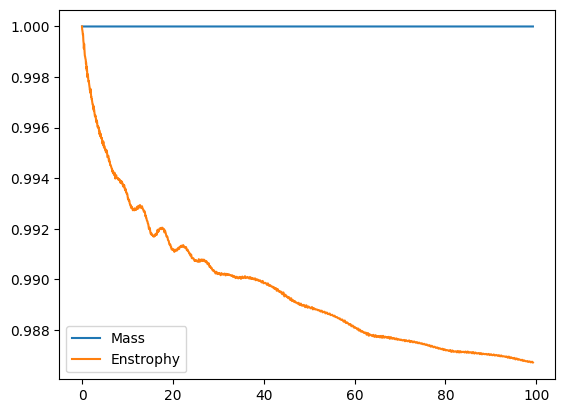

In [19]:
plt.plot(times,mass_plot, label='Mass')
# plt.plot(times,energy_plot, label='Energy')
plt.plot(times,enstrophy_plot, label='Enstrophy')
plt.legend()
plt.show()

In [20]:
mass_plot

array([1., 1., 1., ..., 1., 1., 1.])